# Study of UNet in PyTorch

<!-- ![image.png](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png) -->
![](https://miro.medium.com/max/1400/0*l23lbOWx-_deTkyk.png)

## Import torch

In [30]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

try:
    from albumentations.pytorch import ToTensorV2
except:
    # In the last version up for 22.05.2022  the function ToTensorV2 will not work!
    !pip install albumentations==0.4.6 
    


# try:
#     import filetype
# except:
#     !pip install filetype
#     import filetype


import albumentations 
from albumentations.pytorch import ToTensorV2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader

start  working with `PyTorch`. 

In [31]:
def torch_settings(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [32]:
device, dtype, num_workers = torch_settings()
torch_seed(seed = 42, deterministic = True)

torch version: 1.11
Using device: cuda
cuda:  cu113
Cuda is available: True
number of devices: 1
Tesla T4
Memory Usage:
Allocated: 2.2 GB
Cached:    2.2 GB
default data type: torch.float32
available number of workers: 2


# Dataset

Here we are using `The Oxford-IIIT Pet Dataset`, which could be found [by this link](https://www.robots.ox.ac.uk/~vgg/data/pets/). The dataset contains set of cats and dogs with corresponding masks. This workshop is inspired by  [this tutorial](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/).

The dataset contains masks with 3 classes:
    1. - pet silhouette;
    2. - background;
    3. - boarder of the mask.
We will use only 1 and 2 classes.

In this workshop we will download data manually, however, let us note that you may find this dataset in the  `torchvision.datasetes`. module.
```python
trainvaldata = torchvision.datasets.OxfordIIITPet(root  = './data',
                                                  split = 'trainval', 
                                                  target_types = 'segmentation',
                                                  download  = True, 
                                                  transform = train_transforms)


testdata = torchvision.datasets.OxfordIIITPet(root = './data', 
                                             split = 'test', 
                                             target_types = 'segmentation',
                                             download  = True, 
                                             transform = test_transforms)
```                                             

In [33]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [34]:
url_images = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
root_directory = os.path.join(os.getcwd(),'data','pets')

archive_name = url_images.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_images, root_directory)


url_anno   = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

archive_name = url_anno.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)

download_and_extract_archive(url_anno, root_directory)

Using downloaded and verified file: /content/data/pets/images.tar.gz
Extracting /content/data/pets/images.tar.gz to /content/data/pets
Using downloaded and verified file: /content/data/pets/annotations.tar.gz
Extracting /content/data/pets/annotations.tar.gz to /content/data/pets


Let's inspect the dataset directory. The dataset contains the sub-directories `images` and `annotations/trimaps` among other. At all archive should contains 7393 images. 

In [35]:
content = os.listdir(root_directory)
print(content)
print('n images = ',len(os.listdir(os.path.join(root_directory, 'images'))))
# print('n anno = ',len(os.listdir(os.path.join(dataset_directory, content[0], "trimaps" ))))

['images', 'annotations', 'images.tar.gz', 'annotations.tar.gz']
n images =  7393


So, we may divide data into train, validation and test sub-sets. For make our experiments faster, let's take just each 5-th image. 

```python
# for filtering only image files!!
images_filenames = [i for i in images_filenames 
                    if os.path.splitext(i)[-1] 
                    in ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')]
```

In [36]:
N_TRAIN = 6000
N_TEST  = 100
STEP    = 5

images_directory = os.path.join(root_directory, "images")
masks_directory  = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = os.listdir(images_directory)

# for filtering only image files!!
images_filenames = [i for i in images_filenames 
                    if os.path.splitext(i)[-1] 
                    in ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')]

os.path.splitext('/path/to/somefile.ext')

random.shuffle(images_filenames)

train_images_filenames = images_filenames[:N_TRAIN:STEP]
val_images_filenames   = images_filenames[N_TRAIN:-N_TEST:STEP]
test_images_filenames  = images_filenames[-N_TEST::STEP]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1200 258 20


For uploading data let's also create our dataset class as inheritance of  `Dataset` form `PyTorch`. The class need to have the following prototype:

```python
class CustomImageDataset(Dataset):
    def __init__(self,...):
        ...

    def __len__(self):
       ...

    def __getitem__(self, idx):
        ...
        return sample
```      
You may find more information  [here](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets) and [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).



Here we will use specific augmentation from albumentations library. This library recommended to use in the semantic segmentation and other computer vision problems. The information can be found on the official [web cite](https://albumentations.ai/) and particularly in [this tutorial](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/) and [this](https://albumentations.ai/docs/examples/example_kaggle_salt/).

In [37]:
from torch.utils.data import Dataset

class PetsDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transforms=None):
        
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory  = masks_directory
        
        self.transforms = transforms

    def __len__(self):
        return len(self.images_filenames)
   
    def preprocess_mask(self, mask):
        mask = np.asarray(mask).astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask
    
    def __getitem__(self, idx):

        image_filename = self.images_filenames[idx]
        
        path_ = os.path.join(images_directory, image_filename)    
        image = np.asarray(Image.open(path_).convert("RGB"))
        
        path_ = os.path.join(masks_directory, image_filename.replace(".jpg", ".png"))    
        mask  = Image.open(path_)
        mask  = self.preprocess_mask(mask)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask  = transformed["mask"]

        return image, mask

In [38]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = A.Compose([A.Resize(280, 280),   
                             A.RandomCrop(256,256),
                             A.ShiftScaleRotate(0.2,0.2, 30),
                             A.RGBShift(25,25,25),
                             A.RandomBrightnessContrast(0.3,0.3),
                             A.Normalize(mean, std),
                             ToTensorV2(),])

test_transform = A.Compose([A.Resize(256, 256), 
                            A.Normalize(mean, std), 
                            ToTensorV2()])

train_dataset = PetsDataset(train_images_filenames, images_directory, masks_directory, transforms=train_transform,)

val_dataset   = PetsDataset(val_images_filenames,   images_directory, masks_directory, transforms=test_transform,)

test_dataset  = PetsDataset(test_images_filenames,  images_directory, masks_directory, transforms=test_transform,)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1200
Valid size: 258
Test size: 20


So we can visualize the data using our visualize_data function

In [39]:
from PIL import Image
def visualize_dataset(dataset, samples=5, predicted_masks = None, mean = mean, std = std):
    dataset = copy.deepcopy(dataset)
    cols = 3 if predicted_masks else 2
    
    figure, ax = plt.subplots(nrows=samples, ncols=cols, figsize=(10, 12))
    
    for i in range(samples):
        image, mask = dataset[i]
        
        image = image.data.cpu().numpy().transpose((1,2,0))
        image = np.clip(image*std + mean,0,1)
        
        mask = np.clip(mask,0,1)

        ax[i, 0].imshow(image)
        ax[i, 0].set_title("Image"); ax[i, 0].set_axis_off()
        ax[i, 1].imshow(mask.data.cpu().numpy(), interpolation="nearest")
        ax[i, 1].set_title("Ground Truth");  ax[i, 1].set_axis_off()     
        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted Mask"); ax[i, 2].set_axis_off()
    
    plt.tight_layout()
    plt.show()

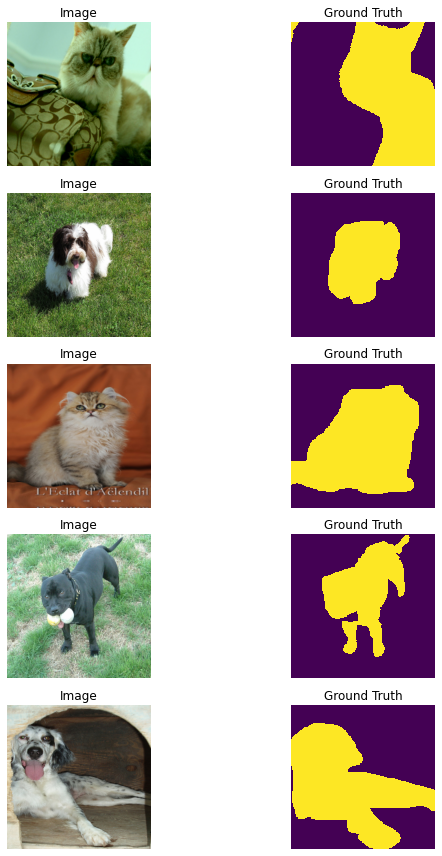

In [40]:
visualize_dataset(train_dataset, samples=5)

Let's now describing dataloaders 

In [41]:
BATCH = 4

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda'), 'pin_memory':True}
else:
     kwarg = {'num_workers':0}

train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH,
                shuffle=True,
                **kwarg)

val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH,
                shuffle=False,
                **kwarg)

test_loader = DataLoader(
                test_dataset,
                batch_size=BATCH,
                shuffle=False,
                **kwarg)

## Truncated U-Net 

So, after dataset uploading we can describe our `U-Net` implementation. Our version of U-Net is restricted example, You may also meet more large architecture [here](https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py) . 


In [42]:
SIZE = 32

def conv_block(in_channels, out_channels, mid_channels = None):
    if mid_channels is None:
        mid_channels = out_channels
    
    return nn.Sequential(
        nn.Conv2d(in_channels,  mid_channels, 3, padding=1, bias = False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),        
        nn.Conv2d(mid_channels, out_channels, 3, padding=1, bias = False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True))   

class UNet(nn.Module):

    def __init__(self, n_channels = 1, n_class=1):
        super().__init__()
                
        self.down1 = conv_block(n_channels, SIZE)
        self.down2 = conv_block(SIZE,       SIZE*2)
        self.down3 = conv_block(SIZE*2,     SIZE*4)
        self.down4 = conv_block(SIZE*4,     SIZE*8)        

        self.maxpool  = nn.MaxPool2d(2)
        
        self.upsample = nn.Upsample(scale_factor=2, 
                                    mode='bilinear', 
                                    align_corners=True)
        
        
        self.up3 = conv_block(SIZE*4 + SIZE*8, SIZE*4)
        self.up2 = conv_block(SIZE*2 + SIZE*4, SIZE*2)
        self.up1 = conv_block(SIZE*2 + SIZE,   SIZE)
        
        self.out = nn.Conv2d(SIZE, n_class, 3, padding=1)
      
    #---------------------------------------------    
    def forward(self, x):
        
        #ENCODER
        conv1 = self.down1(x)
        x = self.maxpool(conv1)

        conv2 = self.down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.down3(x)
        x = self.maxpool(conv3)   
        
        x = self.down4(x)
        
        #DECODER
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.up1(x)
        
        out = self.out(x)
        
        return out

In [43]:
model = UNet(n_channels=3, n_class=1)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

Frequently in this case we use lose function as combination of `Dice` and `cross-entropy`. The `Dice` corresponds to so-called   soft Serence-Dice Distance ($1-\text{Dice}$).

The `Dice` as measure represents relation of doubled area of intersection between ground truth mask to sum of both areas. The corresponding Dice distance can be given as:

$$dice = 1 - \frac {2\cdot(A\cap B)}{|A|+|B|}$$
 or
 $$dice = 1 - \frac {2\cdot(A\cap B)+1}{|A|+|B| +1}$$
where $A,B$ are the areas for both objects;  $\cap$ - is the intersection.



For the training we will use the BCELoss factor of shape correction, and Dice Loss as a factor of shape correspondence here are illustration of how Dice work.

![](https://miro.medium.com/max/858/1*yUd5ckecHjWZf6hGrdlwzA.png)

For implementation we create `dice_loss` and class of new loss `DiceBCELoss`. This class is corresponds to the `Loss Function Library`, [here](https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook) and [here](https://github.com/JunMa11/SegLoss/tree/master/losses_pytorch).

In [44]:
def dice_loss(pred, target, smooth=1):
    #flatten label and prediction tensors
    
    pred    = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()                            
    loss = 1 - (2.*intersection + smooth)/(pred.sum() + target.sum() + smooth)  
    
    return loss

class DiceBCELoss(nn.Module):
    def __init__(self, weight=1):
        super().__init__()
        self.weight = weight

    def forward(self, pred, target, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        pred = torch.sigmoid(pred)       
        
        dice = dice_loss(pred, target, smooth=1)
        
        bce = F.binary_cross_entropy(pred.squeeze(), target.squeeze(), reduction='mean')
        dice_bce = self.weight*bce + dice*(1-self.weight)
        
        return dice_bce

In [45]:
LR = 0.001

model = model.to(device)

criterion = DiceBCELoss(weight = 0.5)

criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)



Also, we will describe accuracy as dice coefficient

$$\text{dice coefficient} = \frac {2\cdot(A\cap B)}{|A|+|B|}\to\text{accuracy}$$

In [46]:
def accuracy(y_pred, y):
    return 1-dice_loss(torch.sigmoid(y_pred), y, smooth=1)
    
#-----------------------------
def train(model, dataloader, optimizer, criterion, metrics, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metrics( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#--------------------------
def evaluate(model, dataloader, criterion,metrics, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metrics( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


weights init

In [47]:
def init_weights(m):

    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    elif isinstance(m, nn.Linear): 
        nn.init.xavier_uniform_(m.weight)

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if m.bias != None:
            m.bias.data.fill_(0)
            
model.apply(init_weights);

In [19]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model, 
                                                train_loader, 
                                                optimizer, 
                                                criterion,
                                                accuracy, 
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   val_loader, 
                                                   criterion, 
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 52s
	Train Loss: 0.455 | Train Acc: 65.49%
	 Val. Loss: 0.443 |  Val. Acc: 68.39%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 52s
	Train Loss: 0.410 | Train Acc: 69.35%
	 Val. Loss: 0.414 |  Val. Acc: 66.57%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s
	Train Loss: 0.380 | Train Acc: 71.91%
	 Val. Loss: 0.346 |  Val. Acc: 72.45%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 50s
	Train Loss: 0.345 | Train Acc: 74.64%
	 Val. Loss: 0.321 |  Val. Acc: 75.26%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 51s
	Train Loss: 0.334 | Train Acc: 75.57%
	 Val. Loss: 0.286 |  Val. Acc: 76.01%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 51s
	Train Loss: 0.319 | Train Acc: 76.66%
	 Val. Loss: 0.308 |  Val. Acc: 77.75%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 51s
	Train Loss: 0.300 | Train Acc: 78.14%
	 Val. Loss: 0.269 |  Val. Acc: 79.35%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 51s
	Train Loss: 0.292 | Train Acc: 78.74%
	 Val. Loss: 0.281 |  Val. Acc: 79.37%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 51s
	Train Loss: 0.279 | Train Acc: 79.71%
	 Val. Loss: 0.253 |  Val. Acc: 81.63%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 51s
	Train Loss: 0.273 | Train Acc: 80.20%
	 Val. Loss: 0.247 |  Val. Acc: 80.47%


+After training we can load the best model

In [48]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, val_loader, criterion,accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

FileNotFoundError: ignored

Then check the outputs

In [49]:
x,y = next(iter(val_loader))

x = x.to(device)
y = y.to(device)

y_pred = torch.sigmoid(model.forward(x))


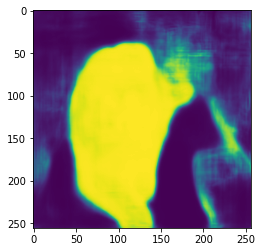

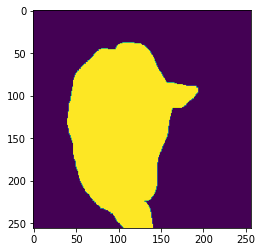

In [22]:
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[1,:,:].detach().cpu().numpy()); plt.show()

actually we need to estimate predicted mask  by some threshold value. It means make binarizing of output with rest only pixels with value higher than the threshold probability (higher than the confidence level).

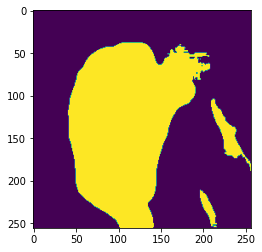

In [26]:
threshold = 0.5
y_pred[y_pred>=threshold]=1
y_pred[y_pred<threshold]=0
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()

## Exercise

**Exercise 1** 

1. Transform `UNet` model to `DeconvNet` model by dropping the encoder-decoder connections and replace upsampling with transposed convolution.  Train the model and compare the results.
2. Try to train the full model from https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py and https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py files. Compare the results.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits    

**Exercise 2** <br>
Actually, in may cases there are no ncessary to train the segmentation model from scratch. Thus we can use some prepared models. For instance, you may use library [`segmentation_models_pytorch`](https://github.com/qubvel/segmentation_models.pytorch). Here you may find [official documentation](efficientnet-b0) and here you may [find official tutorials](https://github.com/qubvel/segmentation_models.pytorch/tree/master/examples). For out problem the usage of `segmentation_models_pytorch` could be as the follows. 

In [58]:
try:
    import segmentation_models_pytorch
except:
    !pip install segmentation_models_pytorch

import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained efficientnet backbone
model = smp.Unet(encoder_name="efficientnet-b0", encoder_weights="imagenet", classes=1,)


We will repeat the training initialization, but you may also use loss function variants from `smp`, like 
```python
criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
criterion.to(device)
```
you may find list of aviliable loss functions [here](https://smp.readthedocs.io/en/latest/losses.html).

In [59]:
LR = 0.001
model = model.to(device)
criterion = DiceBCELoss(weight = 0.5)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [60]:
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model, 
                                                train_loader, 
                                                optimizer, 
                                                criterion,
                                                accuracy, 
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   val_loader, 
                                                   criterion, 
                                                   accuracy,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 44s
	Train Loss: 0.201 | Train Acc: 86.02%
	 Val. Loss: 0.140 |  Val. Acc: 88.95%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 45s
	Train Loss: 0.162 | Train Acc: 89.05%
	 Val. Loss: 0.172 |  Val. Acc: 89.92%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 47s
	Train Loss: 0.134 | Train Acc: 90.80%
	 Val. Loss: 0.145 |  Val. Acc: 88.54%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 45s
	Train Loss: 0.134 | Train Acc: 90.76%
	 Val. Loss: 0.149 |  Val. Acc: 87.99%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 45s
	Train Loss: 0.136 | Train Acc: 90.63%
	 Val. Loss: 0.127 |  Val. Acc: 91.18%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 45s
	Train Loss: 0.120 | Train Acc: 91.80%
	 Val. Loss: 0.128 |  Val. Acc: 90.77%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 45s
	Train Loss: 0.120 | Train Acc: 91.73%
	 Val. Loss: 0.123 |  Val. Acc: 90.98%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 45s
	Train Loss: 0.111 | Train Acc: 92.44%
	 Val. Loss: 0.122 |  Val. Acc: 91.82%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 47s
	Train Loss: 0.102 | Train Acc: 92.95%
	 Val. Loss: 0.120 |  Val. Acc: 91.70%


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 45s
	Train Loss: 0.107 | Train Acc: 92.65%
	 Val. Loss: 0.126 |  Val. Acc: 91.47%


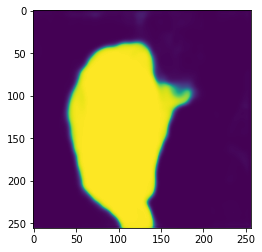

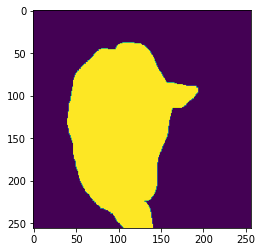

In [61]:
x,y = next(iter(val_loader))
x = x.to(device)
y = y.to(device)
y_pred = torch.sigmoid(model.forward(x))
plt.imshow(y_pred[1,0,:,:].detach().cpu().numpy()); plt.show()
plt.imshow(y[1,:,:].detach().cpu().numpy()); plt.show()

**Exercise 2 - task**  Try to cmapare several variants of segmentation models from `smp`. You may find list of models [here](https://github.com/qubvel/segmentation_models.pytorch#models) and list of encoders [here](https://github.com/qubvel/segmentation_models.pytorch#encoders).